# INSERT TITLE

Examproject by Josefine Pedersen, Viktor Texel and Pernille Svendsen

**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

*Imports and set magics:*

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
from types import SimpleNamespace
from scipy import optimize

# Predefine options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Importing our own code
import examproject as ep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

**Insert introduction**

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [ ]:
# Parameters
alpha, kappa, v, omega, tau, omega_2 = sm.symbols('alpha kappa v omega tau omega_2')

# Variables
G, C, L, = sm.symbols('G C L')

In [ ]:
# We define functions

utility = sm.ln(C**alpha * G**(1-alpha))-v*(L**2/2)
constraint = kappa + (1-tau)*omega*L
constraint_subs = constraint.subs((1-tau)*omega, omega_2)
constraint_subs

In [ ]:
utility_subs = utility.subs(C, constraint_subs)
utility_subs

In [ ]:
# We solve FOC for L
foc = sm.diff(utility_subs, L)
foc
foc2 = sm.simplify(foc)
foc2

In [ ]:
L_star = sm.solve(foc2, L)
L_star[0]


In [ ]:
# We define the answer, as sympy is not able to solve the equation properly
L_star_omega2 = (-kappa+sm.sqrt(kappa**2+4*alpha/v*omega_2))/(2*omega_2)
L_star_omega2

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [ ]:
L_star_func = sm.lambdify((kappa, alpha, v, omega_2), L_star_omega2)

L_vec = []
for omega in range(1, 10):
    omega_val = 0.1*omega
    tau = 0.3
    omega_tilde = (1-tau)*omega_val
    L_val = L_star_func(1, 0.5, 1/(2*16**2), omega_tilde)
    L_vec.append(L_val)

omega_vec = np.linspace(0.1, len(L_vec), len(L_vec))

In [ ]:
# We plot the figure
fig1 = plt.figure(figsize=(9, 4))
ax = fig1.add_subplot(1, 1, 1)

ax.plot(omega_vec, L_vec, ls='-', lw=2, color='blue')

ax.set_xlabel('$\omega_{tilde}$')
ax.set_ylabel('$ L^* $')
ax.set_title('Relationship between labour supply and disposable real wage \n');


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


In [ ]:
# Define baseline parameters
par = SimpleNamespace()
par.alpha = 0.5
par.kappa = 1
par.v = 1/(2*16^2)
par.omega = 1
par.tau = 0.3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate data for the plot
tau_values = np.linspace(0.001, 0.999, 100)

# Create empty lists to store the data that we are going to plot
L_vec = []
G_vec = []
tau_vec = []
utility_vec = []

for tau_val in tau_values:
    tau_vec.append(tau_val)
    omega_tilde = (1-tau_val)*par.omega
    L_val = L_star_func(par.kappa, par.alpha, par.v, omega_tilde)
    L_vec.append(L_val)
    G_val = tau_val*par.omega*L_val*((1-tau_val)*par.omega)
    G_vec.append(G_val)
    u_val = np.log(G_val**(1-par.alpha)*(par.kappa+(1-tau_val)*par.omega*L_val)) - par.v*(L_val**2/2)
    utility_vec.append(u_val)


# Create plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec, L_vec, label='Labor Supply')
ax.plot(tau_vec, G_vec, label='Government Consumption')
ax.plot(tau_vec, utility_vec, label='Utility')


# Set labels and title
ax.set_xlabel('Tax Rate (tau)')
ax.set_ylabel('Government Consumption, Labor Supply, and Worker Utility')
ax.set_title('Relationship between Tax Rate, Government Consumption, Labor Supply, and Worker Utility')

# Add a legend
ax.legend()

# Show the plot
plt.show();

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [ ]:
utility_subs_new = utility.subs(C, constraint)
gov_cons = tau*omega*L*((1-tau)*omega)
utility_subs_new2 = utility_subs_new.subs(G, gov_cons)
utility_subs_new3 = utility_subs_new2.subs(L, L_star_omega2)
utility_subs_new3


In [ ]:
# We solve FOC for tau
foc = sm.diff(utility_subs_new3, tau)
foc

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each hairdresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [ ]:
# Defining baseline parameters
par2 = SimpleNamespace()
par2.eta = 0.5
par2.w = 1

In [ ]:
# Define function
def profit(kappa, par2):

    # a. solve
    obj = lambda l: -(kappa*l**(1-par2.eta)-par2.w*l)
    x0 = [0.0]
    res = optimize.minimize(obj,x0,method='L-BFGS-B')
        
    # b. save
    l_star = res.x[0]

    return l_star


In [ ]:
# Check if given solution matches numerical solution
for kappa in [1.01, 1.2, 1.4, 1.6, 1.8, 1.99]:
    l = profit(kappa, par2)
    l_given = ((1-par2.eta)*kappa/par2.w)**(1/par2.eta)
    print(f'kappa = {kappa:.1f} gives l = {l:.2f} and given solution is {l_given:.2f}')
    

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [ ]:
# We set baseline parameters for the dynamic model
par2.rho = 0.90
par2.iota = 0.01
par2.sigma = 0.1
par2.R = (1+0.01)**(1/12)

In [ ]:
# We define the demand-shock

# Mean of the distribution
mu = -0.5*par2.sigma**2 

# Standard deviation of the distribution
sigma = par2.sigma  

# Set a random seed for reproducibility
np.random.seed(2805)

# Number of random numbers to generate
n = 120
epsilon = np.random.normal(mu, sigma, n)

log_kappa = []

for i,eps in enumerate(epsilon):
    if i == 0:
        log_kappa.append(np.log(1))
    else:
        log_kappa.append(par2.rho*log_kappa[i-1]+eps)

In [ ]:
t = np.linspace(0, n, n)
l = np.ones(n)
l_vec1 = l[:]*(((1-par2.eta)*np.exp(log_kappa))/par2.w)**(1/par2.eta)
l_vec1[0] = 0

 
def h(log_kappa,l): 
    if l[i] != l[i-1]:
        return np.sum(par2.R**-t*(np.exp(log_kappa)*l**(1-par2.eta)-par2.w*l-par2.iota))
    else:
        return np.sum(par2.R**-t*(np.exp(log_kappa)*l**(1-par2.eta)-par2.w*l))

h(log_kappa,l_vec1)

In [ ]:
def value(K,l):
    H_sum = []
    for k in range(0,K-1):
        np.random.seed(k)
        epsilon = np.random.normal(mu, sigma, n)
        log_kappa_k = []
        for i,eps in enumerate(epsilon):
            if i == 0:
                log_kappa_k.append(np.log(1))
            else:
                log_kappa_k.append(par2.rho*log_kappa[i-1]+eps)
        h_k = h(log_kappa_k,l)
        H_sum.append(h_k)

    H = 1/K*np.sum(H_sum)
    return H


value(120,l_vec1)

In [ ]:
for K in range(10,105,5):
    val_salon = value(K,l_vec1)
    print(f'K = {K:.1f} gives value = {val_salon:.2f}')

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [ ]:
l_star = (((1-par2.eta)*np.exp(log_kappa))/par2.w)**(1/par2.eta)

def l_vec2(delta):
    l_vec2 = np.zeros_like(l_star)
    l_vec2[0] = 0
    for i in range(1, len(l_vec2)):
        if np.abs(l_vec2[i-1]-l_star[i]) > delta:
            l_vec2[i] = l_star[i]
        else:
            l_vec2[i] = l_vec2[i-1]
    return l_vec2

q3 = value(10,l_vec2(0.05))
q2 = value(10,l_vec1)

print(f'q2: {q2:.2f} and q3: {q3:.2f}')

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [ ]:
# Define function
def value_opt(par2,do_print=False):

    def obj(delta):
        return -value(10,l_vec2(delta))

    delta0 = [0.05]
    res = optimize.minimize(obj,delta0,method='Nelder-Mead')
        
    # b. save
    delta_star = res.x[0]

    if do_print:
        print(f'optimal delta: {delta_star:.3f}')
    else:
        return delta_star

value_opt(par2,do_print=True)

In [ ]:
# Generate data for the plot
delta_values = np.linspace(0.001, 0.999, 100)

# Create empty lists to store the data that we are going to plot
value_vec = []


for delta_val in delta_values:
    value_val = value(10,l_vec2(delta_val))
    value_vec.append(value_val)

opt_delta = value_opt(par2)
val_opt_delta = value(10,l_vec2(opt_delta))

# Create plot
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
ax.plot(delta_values, value_vec, label='Value')
ax.scatter(opt_delta, val_opt_delta, label='Optimal delta')



# Set labels and title
ax.set_xlabel('Delta')
ax.set_ylabel('Value')
ax.set_title('Value of hair salon for different delta values')

# Add a legend
ax.legend()

# Show the plot
plt.show();


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [ ]:
def l_vec3(factor):
    l_vec3 = np.zeros_like(l_star)
    l_vec3[0] = 0
    for i in range(1, len(l_vec3)):
        if i < 12:
            l_vec3[i] = l_star[i]*factor
        else:
            l_vec3[i] = l_star[i]
    return l_vec3

q4 = value(10,l_vec3(1.5))
q2 = value(10,l_vec1)

print(f'q2: {q2:.2f} and q4: {q4:.2f}')

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [53]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [94]:
# xxxx
def refined_global_optimizer(bounds, tolerance, warmup_iters, max_iters):
    # Step 1: Choose bounds for x and tolerance
    x_bounds = bounds
    tau = tolerance
    
    # Step 2: Choose warm-up and maximum iterations
    K_warmup = warmup_iters
    K_max = max_iters
    
    # Step 3: Iterations

    # Initialize x_star
    x_star = None

    # Create empty list to store x_k0
    x_k0_vec = []

    for k in range(K_max):
        # Step 3A: Draw random x^k uniformly within chosen bounds
        x_k = np.random.uniform(bounds[0], bounds[1], size=2)
        
        if k < K_warmup:
            # Step 3E: Run optimizer with x^k as initial guess
            res = optimize.minimize(griewank, x_k, method='BFGS', tol=tau)
            x_k_star = res.x
            x_k0_vec.append(x_k_star)

        else:
            # Step 3C: Calculate chi^k
            chi_k = 0.5 * (2 / (1 + np.exp((k - K_warmup) / 100)))
            
            # Step 3D: Calculate x_k0
            x_k0 = chi_k * x_k + (1 - chi_k) * x_star
            x_k0_vec.append(x_k0)
            
            # Step 3E: Run optimizer with x_k0 as initial guess
            res = optimize.minimize(griewank, x_k0, method='BFGS', tol=tau) 
            x_k_star = res.x
        
        # Step 3F: Update x_star if necessary
        if k==0 or griewank(x_k_star) < griewank(x_star):
            x_star = x_k_star
        
        # Step 3G: Check termination condition
        if griewank(x_star) < tau:
            nit = k
            break
    
    # Step 4: Return the result x_star
    return x_star, x_k0_vec, nit


# Choose bounds, tolerance, warmup and maximum iterations
bounds = [-600, 600]
tolerance = 1e-8
warmup_iters = 10
max_iters = 1000

# Run the refined global optimizer
np.random.seed(300)
result = refined_global_optimizer(bounds, tolerance, warmup_iters, max_iters)

# Print the result
print("Optimal solution:", result[0])


Optimal solution: [-1.27094113e-08 -1.67465841e-08]


In [95]:
print("Optimal solution:", result[2])


Optimal solution: 365


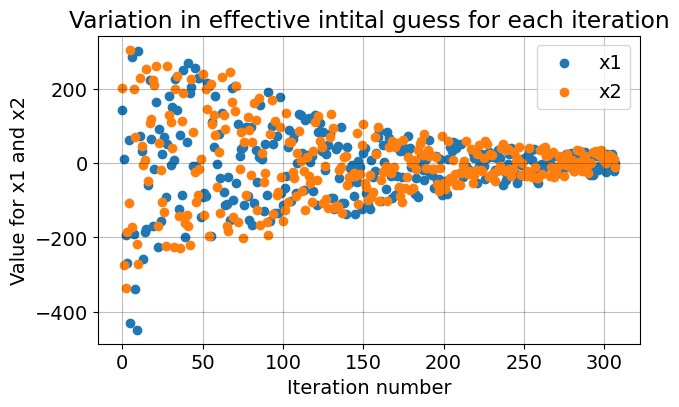

In [89]:
x_k0_vec = result[1]
x_k0_vec

x1_vec = [point[0] for point in x_k0_vec]  # Extract the first element (x1) from each point
x2_vec = [point[1] for point in x_k0_vec]  # Extract the second element (x2) from each point

# Create plot
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
plt.scatter(np.arange(len(x1_vec)), x1_vec, label='x1')
plt.scatter(np.arange(len(x2_vec)), x2_vec, label='x2')

# Set labels and title
ax.set_xlabel('Iteration number')
ax.set_ylabel('Value for x1 and x2')
ax.set_title('Variation in effective intital guess for each iteration')

# Add a legend
ax.legend()

# Show the plot
plt.show();

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [96]:
warmup_iters = 100
result = refined_global_optimizer(bounds, tolerance, warmup_iters, max_iters)
result[2]

476

# Conclusion

**INSERT TEXT**